In [88]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.linear_model import LogisticRegression
from itertools import combinations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Load Model Evaluation Results on Static Benchmark Questions

In [89]:
static_df = pd.read_csv("./data/static_5_models.csv")
len(static_df)
arena_data = load_dataset("lmarena-ai/arena-human-preference-140k")['train']

In [90]:
static_df.head(10)

,question_id,question,model_name,correct_answer,model_answer,judge_result,level
0,MMLU-abstract_1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...",gpt-4o-mini,24,"The order of the permutation \( p = (1, 2, 5, ...",0,NaN
1,MMLU-abstract_1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...",grok-3-mini-beta,24,"To solve this, first determine the permutation...",1,NaN
2,MMLU-abstract_1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...",claude-3-5-haiku-20241022,24,"Let me solve this step by step:\n\n1) First, l...",0,NaN
3,MMLU-abstract_1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...",gemini-2.0-flash,24,60,0,NaN
4,MMLU-abstract_1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...",llama-3.3-70b-it,24,60,0,NaN
5,MMLU-abstract_2,Find all zeros in the indicated finite field o...,gpt-4o-mini,"0,4",The zeros of the polynomial \( x^5 + 3x^3 + x^...,0,NaN
6,MMLU-abstract_2,Find all zeros in the indicated finite field o...,grok-3-mini-beta,"0,4",To find the zeros of the polynomial \(x^5 + 3x...,0,NaN
7,MMLU-abstract_2,Find all zeros in the indicated finite field o...,claude-3-5-haiku-20241022,"0,4",Let me solve this step by step:\n\n1) I'll che...,0,NaN
8,MMLU-abstract_2,Find all zeros in the indicated finite field o...,gemini-2.0-flash,"0,4","{0, 1, 2}",0,NaN
9,MMLU-abstract_2,Find all zeros in the indicated finite field o...,llama-3.3-70b-it,"0,4","0, 2, 4",0,NaN


# Static Baseline: Ranking Item-level Difficulty Based on Number of Correct Models

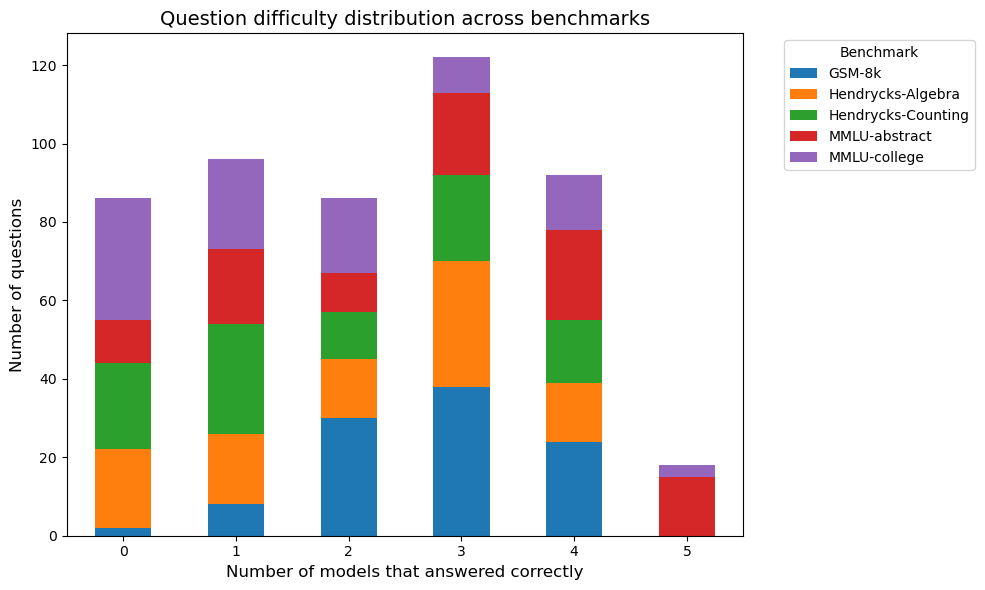

In [98]:
difficulty_df = (
    static_df.groupby("question_id")["judge_result"]
    .agg(num_correct="sum", num_attempts="count")
    .reset_index()
)

difficulty_df["benchmark"] = difficulty_df["question_id"].str.rsplit("_", n=1).str[0]

count_df = (
    difficulty_df.groupby(["num_correct", "benchmark"])
    .size()
    .unstack(fill_value=0)
    .reindex(range(6), fill_value=0) 
)

count_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
)

plt.xlabel("Number of models that answered correctly", fontsize=12)
plt.ylabel("Number of questions", fontsize=12)
plt.title("Question difficulty distribution across benchmarks", fontsize=14)
plt.xticks(rotation=0)  
plt.legend(title="Benchmark", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("./figures/naive_ranking.pdf", dpi=500)
plt.show()

In [92]:
static_naive_ranking = difficulty_df.sort_values(by="num_correct").copy()
static_naive_ranking

,question_id,num_correct,num_attempts,benchmark
499,MMLU-college_99,0,5,MMLU-college
497,MMLU-college_97,0,5,MMLU-college
496,MMLU-college_96,0,5,MMLU-college
492,MMLU-college_92,0,5,MMLU-college
426,MMLU-college_32,0,5,MMLU-college
...,...,...,...,...
336,MMLU-abstract_40,5,5,MMLU-abstract
323,MMLU-abstract_29,5,5,MMLU-abstract
427,MMLU-college_33,5,5,MMLU-college
398,MMLU-abstract_97,5,5,MMLU-abstract


# 1-Parameter Logistic IRT for Static Benchmark Questions

In [93]:
def fit_1pl_irt(static_df, C=1e6, max_iter=2000):
    """
    Fit a 1-parameter IRT (Rasch) model using logistic regression.

    Model:
        logit P(correct_{i,q}) = theta_i - b_q

    Returns
    -------
    model_ranking : DataFrame
        columns: ['model_name', 'theta'], sorted descending by theta.
    question_ranking : DataFrame
        columns: ['question_id', 'difficulty_b'], sorted descending by difficulty_b.
    """
    df = static_df.copy()

    # 1) Encode models and questions as categorical indices
    df["model_cat"] = df["model_name"].astype("category")
    df["question_cat"] = df["question_id"].astype("category")

    df["model_idx"] = df["model_cat"].cat.codes
    df["question_idx"] = df["question_cat"].cat.codes

    n_models = df["model_idx"].nunique()
    n_questions = df["question_idx"].nunique()

    # 2) Design matrix X so that:
    #    logit P(correct) = theta_model - b_question
    #    Implement as X = [model_one_hot, -question_one_hot]
    X_model = np.eye(n_models)[df["model_idx"]]
    X_question = np.eye(n_questions)[df["question_idx"]]
    X = np.hstack([X_model, -X_question])

    y = df["judge_result"].values  # assumes 0/1

    # 3) Fit logistic regression ≈ Rasch model
    logit = LogisticRegression(
        fit_intercept=False,
        penalty="l2",
        C=C,              # very weak regularization by default
        solver="lbfgs",
        max_iter=max_iter,
    )
    logit.fit(X, y)

    coef = logit.coef_.ravel()

    # 4) Extract raw parameters
    theta_raw = coef[:n_models]     # abilities
    b_raw = coef[n_models:]         # difficulties

    # 5) Enforce sum(theta) = 0 (identifiability)
    theta_mean = theta_raw.mean()
    theta = theta_raw - theta_mean
    b = b_raw - theta_mean          # shift by same constant so (theta_i - b_q) unchanged

    # 6) Build ranking DataFrames
    model_levels = df["model_cat"].cat.categories
    question_levels = df["question_cat"].cat.categories

    model_ranking = (
        pd.DataFrame({"model_name": model_levels, "theta": theta})
        .sort_values("theta", ascending=False)
        .reset_index(drop=True)
    )

    question_ranking = (
        pd.DataFrame({"question_id": question_levels, "difficulty_b": b})
        .sort_values("difficulty_b", ascending=False)  # higher = harder
        .reset_index(drop=True)
    )

    return model_ranking, question_ranking

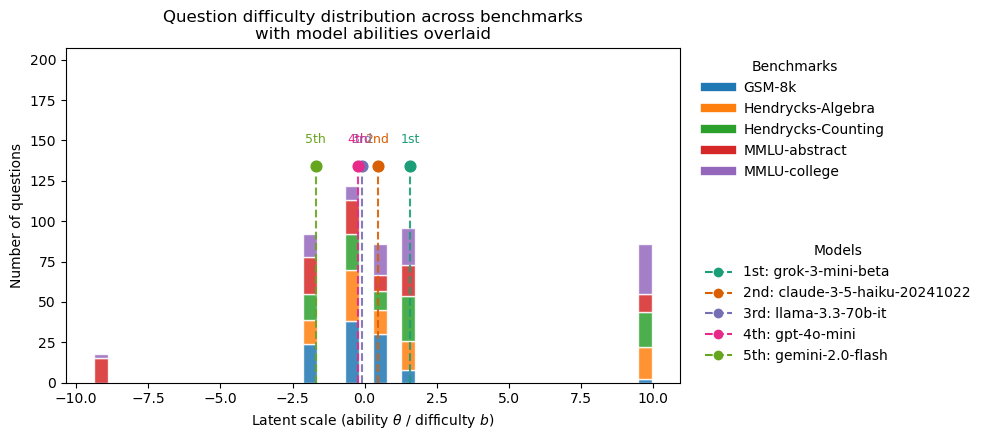

In [94]:
def plot_difficulty_and_ability(model_ranking, question_ranking, bins=40, save_path=None):
    """
    Final version:
    - Stacked histogram of question difficulties by benchmark
    - Model abilities overlaid with ranked labels (1st, 2nd, …)
    - Legends include benchmark and model names
    """

    qr = question_ranking.copy()
    if "benchmark" not in qr.columns:
        qr["benchmark"] = qr["question_id"].astype(str).str.rsplit("_", n=1).str[0]

    benchmarks = sorted(qr["benchmark"].unique())
    bench_colors = plt.cm.tab10.colors[: len(benchmarks)]

    fig, ax = plt.subplots(figsize=(10, 5))

    # ----- stacked histogram -----
    b_vals = qr["difficulty_b"].values
    bin_edges = np.linspace(b_vals.min(), b_vals.max(), bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = np.diff(bin_edges)

    hist_data = []
    for bmk in benchmarks:
        vals = qr.loc[qr["benchmark"] == bmk, "difficulty_b"].values
        hist, _ = np.histogram(vals, bins=bin_edges)
        hist_data.append(hist)
    hist_data = np.array(hist_data)

    bottoms = np.zeros_like(hist_data[0])
    bench_handles = []
    for i, bmk in enumerate(benchmarks):
        bars = ax.bar(
            bin_centers,
            hist_data[i],
            width=bin_widths,
            bottom=bottoms,
            color=bench_colors[i],
            alpha=0.85,
            align="center",
            label=bmk,
            edgecolor="white",
        )
        bottoms += hist_data[i]
        bench_handles.append(Line2D([0], [0], color=bench_colors[i], lw=6, label=bmk))

    y_max = bottoms.max() if len(bottoms) > 0 else 1.0
    ax.set_ylim(0, y_max * 1.7)

    # ----- overlay model abilities -----
    mr_sorted = model_ranking.sort_values("theta", ascending=False).reset_index(drop=True)
    theta_vals = mr_sorted["theta"].values
    model_names = mr_sorted["model_name"].values
    rank_labels = [f"{i+1}{'st' if i==0 else 'nd' if i==1 else 'rd' if i==2 else 'th'}" for i in range(len(model_names))]
    model_colors = plt.cm.Dark2.colors[: len(model_names)]

    model_handles = []
    for i, (theta, name) in enumerate(zip(theta_vals, model_names)):
        color = model_colors[i % len(model_colors)]
        ax.axvline(
            theta,
            0,
            y_max * 1.05 / (y_max * 1.7),
            color=color,
            linestyle="--",
            linewidth=1.5,
            alpha=0.9,
        )
        ax.scatter([theta], [y_max * 1.1], color=color, s=60, zorder=5)
        ax.text(
            theta,
            y_max * 1.2,
            rank_labels[i],
            ha="center",
            va="bottom",
            fontsize=9,
            color=color,
            fontweight="medium",
        )
        model_handles.append(
            Line2D(
                [0], [0],
                color=color,
                linestyle="--",
                marker="o",
                markersize=6,
                label=f"{rank_labels[i]}: {name}",
            )
        )

    # ----- cosmetics & legends -----
    ax.set_xlabel("Latent scale (ability $\\theta$ / difficulty $b$)")
    ax.set_ylabel("Number of questions")
    ax.set_title(
        "Question difficulty distribution across benchmarks\nwith model abilities overlaid"
    )

    # benchmarks and models both in legend
    legend1 = ax.legend(
        handles=bench_handles,
        title="Benchmarks",
        frameon=False,
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
    )
    ax.add_artist(legend1)

    ax.legend(
        handles=model_handles,
        title="Models",
        frameon=False,
        bbox_to_anchor=(1.02, 0.45),
        loc="upper left",
    )

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    if save_path is not None:
        plt.savefig(save_path, dpi=500)
    plt.show()

model_ranking, question_ranking= fit_1pl_irt(static_df)
plot_difficulty_and_ability(model_ranking, question_ranking, save_path="./figures/static_1pl_ranking.pdf")

# Our Unified Ranking Algorithm: Using Static Data to Simulate the Arena Setting

In [95]:
def build_pairwise_from_static(static_df: pd.DataFrame) -> pd.DataFrame:
    """
    From per-(model, question) correctness labels,
    build a pairwise dataset with outcomes:
      - m1_win  (model_1 correct, model_2 wrong)
      - m2_win  (model_1 wrong, model_2 correct)
      - tie     (both correct)
      - both_bad (both wrong)
    """
    rows = []
    for qid, group in static_df.groupby("question_id"):
        # all unordered model pairs for this question
        for (_, r1), (_, r2) in combinations(group.iterrows(), 2):
            m1, m2 = r1["model_name"], r2["model_name"]
            y1, y2 = r1["judge_result"], r2["judge_result"]

            if y1 == 1 and y2 == 0:
                outcome = "m1_win"
            elif y1 == 0 and y2 == 1:
                outcome = "m2_win"
            elif y1 == 1 and y2 == 1:
                outcome = "tie"
            else:
                outcome = "both_bad"

            rows.append(
                {
                    "question_id": qid,
                    "model_1": m1,
                    "model_2": m2,
                    "outcome": outcome,
                }
            )
    return pd.DataFrame(rows)

def fit_pairwise_arena_model(
    static_df: pd.DataFrame,
    num_epochs: int = 2000,
    lr: float = 0.05,
    verbose: bool = True,
):
    """
    Fit the model:
      pi_{i,q} = sigmoid(theta_i - b_q)
      P(m_i > m_j | q) = sigmoid(exp(k_q) * (pi_{i,q} - pi_{j,q}))
    using only decisive pairs (m1_win / m2_win).
    Returns DataFrames for model parameters and question parameters.
    """
    # 2.1 Build pairwise data and keep only win/loss pairs
    pairwise_df = build_pairwise_from_static(static_df)
    train_pairs = pairwise_df[pairwise_df["outcome"].isin(["m1_win", "m2_win"])].copy()

    # Binary label: 1 if model_1 wins, 0 if model_2 wins
    train_pairs["label"] = (train_pairs["outcome"] == "m1_win").astype(float)

    # 2.2 Index models and questions
    model_ids = pd.Index(pd.unique(static_df["model_name"]), name="model_name")
    question_ids = pd.Index(pd.unique(static_df["question_id"]), name="question_id")

    model_to_idx = {m: i for i, m in enumerate(model_ids)}
    q_to_idx = {q: i for i, q in enumerate(question_ids)}

    train_pairs["model_1_idx"] = train_pairs["model_1"].map(model_to_idx)
    train_pairs["model_2_idx"] = train_pairs["model_2"].map(model_to_idx)
    train_pairs["question_idx"] = train_pairs["question_id"].map(q_to_idx)

    m1_idx = torch.tensor(train_pairs["model_1_idx"].values, dtype=torch.long)
    m2_idx = torch.tensor(train_pairs["model_2_idx"].values, dtype=torch.long)
    q_idx = torch.tensor(train_pairs["question_idx"].values, dtype=torch.long)
    y = torch.tensor(train_pairs["label"].values, dtype=torch.float32)

    n_models = len(model_ids)
    n_questions = len(question_ids)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    m1_idx = m1_idx.to(device)
    m2_idx = m2_idx.to(device)
    q_idx = q_idx.to(device)
    y = y.to(device)

    # 2.3 Parameters:
    #   theta_i: ability per model
    #   b_q: difficulty per question
    #   k_q: unconstrained discrimination per question, exp(k_q) > 0
    theta = nn.Embedding(n_models, 1)
    b = nn.Embedding(n_questions, 1)
    k = nn.Embedding(n_questions, 1)

    nn.init.zeros_(theta.weight)
    nn.init.zeros_(b.weight)
    nn.init.zeros_(k.weight)

    params = list(theta.parameters()) + list(b.parameters()) + list(k.parameters())
    optimizer = optim.Adam(params, lr=lr)

    bce = nn.BCEWithLogitsLoss()  

    # 2.4 Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        theta_m1 = theta(m1_idx).squeeze(-1)  # [N]
        theta_m2 = theta(m2_idx).squeeze(-1)  # [N]
        b_q = b(q_idx).squeeze(-1)            # [N]
        k_q = k(q_idx).squeeze(-1)            # [N]

        # latent satisfaction probabilities
        pi_m1 = torch.sigmoid(theta_m1 - b_q)  # pi_{i,q}
        pi_m2 = torch.sigmoid(theta_m2 - b_q)  # pi_{j,q}

        # discrimination: exp(k_q) > 0
        disc_q = torch.exp(k_q)

        # logits for P(m1 > m2 | q) = sigmoid(exp(k_q) * (pi_m1 - pi_m2))
        logits = disc_q * (pi_m1 - pi_m2)

        loss_main = bce(logits, y)

        # small L2 regularization to stabilize scale
        reg = 1e-4 * (
            theta.weight.pow(2).mean()
            + b.weight.pow(2).mean()
            + k.weight.pow(2).mean()
        )

        total_loss = loss_main + reg
        total_loss.backward()
        optimizer.step()

        # identifiability: enforce mean-zero on theta, shift b accordingly.
        with torch.no_grad():
            theta_mean = theta.weight.mean()
            theta.weight.sub_(theta_mean)
            b.weight.sub_(theta_mean)

        if verbose and (epoch % 500 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch:4d} | loss = {total_loss.item():.4f}")

    # 2.5 Extract parameters
    theta_np = theta.weight.detach().cpu().numpy().squeeze(-1)
    b_np = b.weight.detach().cpu().numpy().squeeze(-1)
    k_np = k.weight.detach().cpu().numpy().squeeze(-1)
    disc_np = (torch.exp(k.weight).detach().cpu().numpy().squeeze(-1))

    model_params = pd.DataFrame(
        {
            "model_name": model_ids,
            "theta": theta_np,
        }
    ).sort_values("theta", ascending=False)

    question_params = pd.DataFrame(
        {
            "question_id": question_ids,
            "difficulty_b": b_np,       # higher = harder
            "k_raw": k_np,
            "discrimination_exp_k": disc_np,
        }
    ).sort_values("difficulty_b", ascending=False)

    return model_params, question_params

In [96]:
model_ranking, question_ranking = fit_pairwise_arena_model(static_df, num_epochs=5000, lr=0.05)

print("Model abilities:")
print(model_ranking)

print("\nQuestion difficulty ranking (higher = harder):")
print(question_ranking.head(20))

Epoch    0 | loss = 0.6931
Epoch  500 | loss = 0.2503
Epoch 1000 | loss = 0.2438
Epoch 1500 | loss = 0.2424
Epoch 2000 | loss = 0.2418
Epoch 2500 | loss = 0.2415
Epoch 3000 | loss = 0.2414
Epoch 3500 | loss = 0.2414
Epoch 4000 | loss = 0.2414
Epoch 4500 | loss = 0.2414
Epoch 4999 | loss = 0.2414
Model abilities:
                  model_name      theta
1           grok-3-mini-beta   8.906013
2  claude-3-5-haiku-20241022   5.307586
0                gpt-4o-mini   0.085253
4           llama-3.3-70b-it  -4.246439
3           gemini-2.0-flash -10.052412

Question difficulty ranking (higher = harder):
              question_id  difficulty_b     k_raw  discrimination_exp_k
14       MMLU-abstract_15     10.808342  3.686024             39.885963
123       MMLU-college_25     10.808342  3.686024             39.885963
122       MMLU-college_24     10.808342  3.686024             39.885963
137       MMLU-college_39     10.808342  3.686024             39.885963
54       MMLU-abstract_55     10.80834

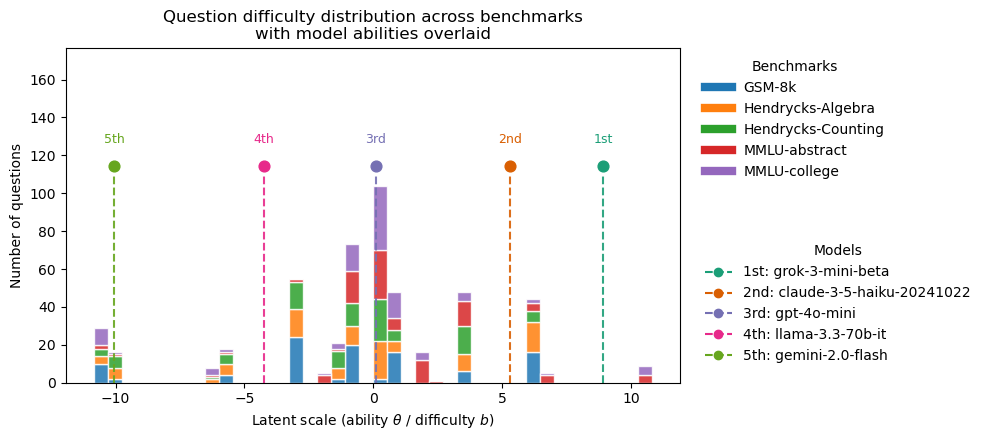

In [97]:
plot_difficulty_and_ability(model_ranking, question_ranking, save_path="./figures/static_sim_ranking.pdf")